## Graph Attention Networks on undirected graph

In [1]:
import sys
sys.path.insert(0, "../../../")
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import numpy as np
import torch
 

data = pd.read_csv(r"../../../extdata/sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/sbc/graph_learning/patient_centric/gcn_conv/../../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/graph_learning/patient_centric/gcn_conv/../../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/sbc/graph_learning/patient_centric/gcn_conv/../../../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A

## Sort data based on ID for matching edge index

In [2]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

## Reading edge index

In [3]:
edge_index = torch.tensor(pd.read_csv("../edge_index/reverse_directed_edge_index.csv", header=None, skiprows=1).values.transpose(), dtype=torch.long)

## Pre-processing categorical variables

In [4]:
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES
data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

## Set features and labels

In [5]:
X_features = torch.tensor(data[FEATURES].values).type(torch.float32)
y = torch.tensor(data["Label"].values).type(torch.long)

## Normalize data

In [6]:
from dataAnalysis.FeatureImportance import normalize

X_features = normalize(X_features)

/home/dwalke/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Reading and adding positional encodings

In [7]:
pos_encodings = pd.read_csv("../positional_encodings/positional_encodings.csv", header=None, skiprows=1)

pos_encodings = pos_encodings.values

In [8]:
X_features

tensor([[ 1.1067, -0.9899,  0.4046,  ...,  0.3607, -0.4256, -0.6549],
        [-1.2956, -0.9899,  2.0656,  ...,  2.3851, -1.3951, -0.3717],
        [-0.6404,  1.0102,  0.8033,  ...,  0.3729,  0.1943,  0.5042],
        ...,
        [-0.1490, -0.9899,  0.4046,  ...,  0.5314, -0.1713, -0.1417],
        [ 0.0693,  1.0102,  1.0690,  ...,  0.8973,  0.2102,  0.8493],
        [ 0.0693,  1.0102,  1.4676,  ...,  1.3851,  0.4804,  1.1501]])

In [9]:
X_new_features = X_features + pos_encodings

## Create train, validation and test masks

In [10]:
def ratio_bool_switch(tensor, ratio = 0.8):
    random = np.random.uniform(0, 1 ,tensor.shape[0])
    val_ratio_mask = (random >= 0.8)
    train_ratio_mask = (random < 0.8)
    val_mask = np.logical_and(tensor.tolist(), val_ratio_mask.tolist())
    train_mask = np.logical_and(tensor.tolist(), train_ratio_mask.tolist())
    return torch.from_numpy(train_mask).type(torch.bool), torch.from_numpy(val_mask).type(torch.bool)

In [11]:
train_mask_ser = data["Set"] != "Validation"
train_mask, val_mask = ratio_bool_switch(train_mask_ser.values)
test_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values, (data["Center"] == "Leipzig").values)).type(torch.bool)
test_gw_mask = torch.from_numpy(np.logical_and((data["Set"] == "Validation").values, (data["Center"] == "Greifswald").values)).type(torch.bool)

In [12]:
train_mask.shape

torch.Size([1819435])

## Create patient-centric graph

In [13]:
from torch_geometric.data import Data

graph = Data(x=X_new_features, train_mask = train_mask, test_mask=test_mask, val_mask=val_mask, y= y, edge_index=edge_index,
             test_gw_mask = test_gw_mask)

## Create graph batches

In [14]:
from torch_geometric.loader import NeighborLoader

kwargs = {
    "num_neighbors":[-1] * 2,
    "batch_size":50_000,
}
loader = NeighborLoader(
    graph,
    input_nodes=graph.train_mask,
    **kwargs
)
val_loader = NeighborLoader(
    graph,
    input_nodes=graph.val_mask,
    **kwargs
)

## Set device

In [15]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

graph = graph.to(device)
WEIGHT = torch.tensor([530])
WEIGHT = WEIGHT.to(device)

print("Data shifted to the device " + str(device))

Data shifted to the device cuda:2


## Define the model

In [16]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv,GATv2Conv, GINConv, SAGEConv
from dataAnalysis.Constants import FEATURES
from torch.nn import Linear, ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm

class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self, hidden_dim = 128, out_channels = 1):
        super(GraphNeuralNetwork, self).__init__()
        input_dim = len(FEATURES)      
        
        conv_1= GCNConv(input_dim, hidden_dim)
        conv_end = GCNConv(hidden_dim, out_channels)
        
        self.conv_1 = conv_1
        self.conv_end = conv_end
        

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index
        x = x.type(torch.float)
        x = self.conv_1(x, edge_index)
        x = F.normalize(x, p=2., dim=-1)
        x = torch.relu(x)
        x = self.conv_end(x, edge_index)
        return x
            
    def predict_proba(self, graph, mask):
        with torch.inference_mode():
            self.eval()
            logits = self.forward(graph)
            scores = torch.sigmoid(torch.squeeze(logits[mask]))
            scores = torch.unsqueeze(scores, 0)
            proba_predict = torch.concat((1- scores, scores), dim = 0)
            return torch.transpose(proba_predict, 0, 1)
            
    def predict(self, graph, mask):
        return torch.round(self.predict_proba(graph, mask)[:, 1])

In [17]:
# graph.y = torch.stack([(graph.y == 0).type(torch.int),
# (graph.y == 1).type(torch.int)])

## Model wrapper for training

In [18]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
class ModelWrapper():
    def __init__(self, train_loader, val_loader):
        self.LEARNING_RATE = 3e-3
        self.MAX_EPOCHS = 10000

        self.model = GraphNeuralNetwork(hidden_dim = 128, out_channels=1) 
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE,betas=(0.9, 0.999), eps=1e-08)
#         self.train_loader = train_loader
#         self.val_loader = val_loader
        
        self.last_loss = 0
        self.increased_loss = 0
        self.BREAKING_THRESHOLD = 5 
        self.val_loss = []
        self.train_loss = []
        self.epochs = self.MAX_EPOCHS
    
    def validate(self):
        with torch.inference_mode():
            self.model.eval()
            acc_loss = 0
            batch_size = 0
            for batch, graph in enumerate(val_loader):
                graph = graph.to(device)
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out)[graph.val_mask], graph.y[graph.val_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
            avg_loss = acc_loss / batch_size
            self.val_loss.append(avg_loss)
            if avg_loss > self.last_loss:
                self.increased_loss += 1
            else:
                self.increased_loss = 0
            self.last_loss = avg_loss

    def train(self):
        for epoch in tqdm(range(self.MAX_EPOCHS)):
            acc_loss = 0
            batch_size = 0
            
            for batch, graph in enumerate(loader):
                graph = graph.to(device)
                self.model.train()
                self.optimizer.zero_grad()
                out = self.model(graph)
                loss = F.binary_cross_entropy_with_logits(torch.squeeze(out)[graph.train_mask], graph.y[graph.train_mask].type(torch.float32),
                                                          pos_weight=WEIGHT)
                acc_loss += loss.item()
                batch_size += 1
                loss.backward()
                self.optimizer.step()
            self.train_loss.append(acc_loss/batch_size)
            self.validate() 

            if self.increased_loss >= self.BREAKING_THRESHOLD:
                self.epochs = epoch + 1
                print(f"Breaked at {str(epoch)}")
                break
            
    def get_model(self):
        return self.model    
    
    def plot_loss(self):
        plt.plot(range(len(self.train_loss)), self.train_loss, 'g', label='Training loss')
        plt.plot(range(len(self.val_loss)), self.val_loss, 'y', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## Train and plot loss curves

In [ ]:
model_wrapper = ModelWrapper(loader, val_loader)
model_wrapper.train()
model_wrapper.plot_loss()

  0%|          | 0/10000 [00:00<?, ?it/s]

## Error evaluation

In [ ]:
import time

models = []
train_times = []
for i in range(10):
    model_wrapper = ModelWrapper(loader, val_loader)
    
    start = time.time()
    model_wrapper.train()
    
    train_times.append(time.time() - start)
    models.append(model_wrapper.get_model().cpu())

## Model back to CPU for evaluation purposes

In [23]:
model = model_wrapper.get_model()
graph = graph.cpu()
model = model.cpu()

In [24]:
torch.save(model.state_dict(), "../models/gcn_models/rev_directed_gat_with_pos_1.pt")

In [25]:
# torch.save(model, "models/rev_directed_gat_with_pos_1.pt")

## Evaluation

,Name,MCC,F1-Micro,F1-Macro,F1-Binary,AUROC,AUPRC
0,Leipzig,0.100189,0.925438,0.494534,0.027836,0.951700,0.050610
1,Greifswald,0.089354,0.926091,0.491733,0.021872,0.950185,0.037731


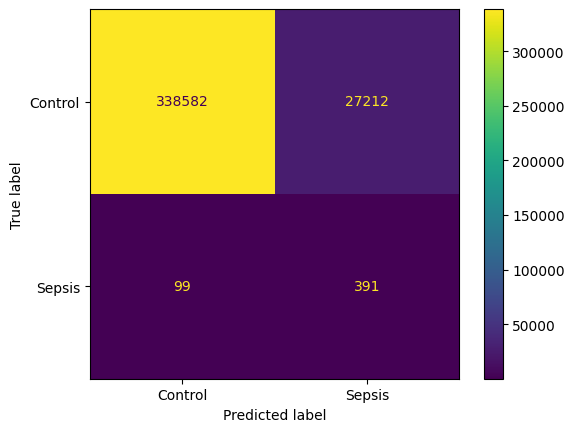

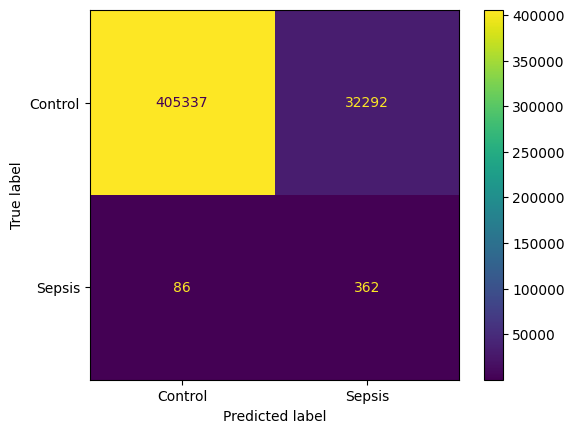

In [26]:
from dataAnalysis.Metrics import Evaluation

y_dict = Evaluation.create_y_dict(model.predict(graph, test_mask), model.predict_proba(graph, test_mask) , graph.y[test_mask])
y_dict_gw = Evaluation.create_y_dict(model.predict(graph, test_gw_mask), model.predict_proba(graph, test_gw_mask) , graph.y[test_gw_mask])

Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, test_mask), graph.y[test_mask])
Evaluation.plot_confusion_matrix_from_pred(model.predict(graph, test_gw_mask), graph.y[test_gw_mask])
Evaluation.get_df_metrics_from_pred(y_dict, y_dict_gw)